<a href="https://colab.research.google.com/github/shlff/CompEcon/blob/main/05_ha_with_epstein_zin_utility.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade quantecon

In [ ]:
!nvidia-smi

Wed Apr  3 08:02:18 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off | 00000000:00:04.0 Off |                    0 |
| N/A   31C    P0              41W / 350W |      2MiB / 40960MiB |      0%      Default |
|                                         |                      |             Disabled |
+-----------------------------------------+----------------------+--

In [ ]:
import quantecon as qe
import matplotlib.pyplot as plt
import numpy as np
import jax
import jax.numpy as jnp
# import empirical_ccdf as eccdf
# import tail_estimate as te

from numba import prange, njit, jit

In [ ]:
jax.config.update("jax_enable_x64", True)

## 1 Find the policy function: optimal consumption rule

Consider a single agent solves an aiyagari model with the following constraint
$$
a_{t+1} = R_{t+1} (a_t - c_t) + Y_{t+1}
$$
where
- $R_t := R (Z_t, \zeta_t)$ and $R(Z, \zeta): = \exp (a_r \zeta + b_r Z + c_r)$
- $Y_t := Y (Z_t, \eta_t)$ and $Y(Z, \eta): = \exp (a_y \eta + b_y Z + c_y )$
<!-- - $\beta_t := \beta (Z_t, \epsilon_t)$ and $\beta(Z, \zeta): = \exp (a_{\beta} \epsilon + b_{\beta} Z + c_r )$  (ignore this for now and add this to the next setting) -->

In the following we assume $b_r=0$ unless stated.

### 1-1 basics

#### jax

In [ ]:
def ifp(β=0.99,             # discount factor
        γ=1.5,              # CRRA preference parameter
        s_max=16,           # savings grid max
        s_size=200,         # savings grid size
        ρ=0.99,             # aggregate shock persistence
        ν=0.01,             # aggregate shock volatility
        a_r=0.1,            # para for idiosyn shock in R
        b_r=0.0,            # para for agg shock in R
        c_r=0.0,            # location para in R
        a_y=0.2,            # para for idiosyn shock in Y
        b_y=0.5,            # para for agg shock in Y
        c_y=0.1,            # location para in Y
        zshock_size=2,      # the number of agg shock states
        ishock_size=50,     # size for idiosyn shocks
        seed=234234,        # seed for PRNG state
        T=1_000_000):       # simulation length

    # Set the key (explicit PRNG state)
    key = jax.random.PRNGKey(seed)     # to be passed to JAX random functions

    # Create exo shock Markov chain
    mc = qe.tauchen(zshock_size, ρ, ν)
    z_grid, P = jnp.exp(mc.state_values), mc.P

    # Create arrays
    s_grid = jnp.exp(jnp.linspace(0, s_max, s_size))
    ζ_draws = jax.random.normal(key=key, shape=[ishock_size])
    η_draws = jax.random.normal(key=key, shape=[ishock_size])

    # Shift to JAX arrays
    P, z_grid = jax.device_put((P, z_grid))

    # require R β < 1 for convergence
    if b_r == 0:
        ER = jnp.exp(a_r**2 / 2 + c_r)
    assert ER * β < 1, "Stability condition failed."

    # Pack and return
    constants = β, γ, T, a_r, b_r, c_r, a_y, b_y, c_y
    sizes = s_size, zshock_size, ishock_size
    arrays = s_grid, z_grid, P, ζ_draws, η_draws

    return constants, sizes, arrays

In [ ]:
def K_egm(a_in, σ_in, constants, sizes, arrays):
    """
    The vectorized operator K using EGM.

    """

    # Unpack
    β, γ, T, a_r, b_r, c_r, a_y, b_y, c_y = constants
    s_size, zshock_size, ishock_size = sizes
    s_grid, z_grid, P, ζ_draws, η_draws = arrays

    def u_prime(c):
        return c**(-γ)

    def u_prime_inv(u):
            return u**(-1/γ)

    def R(z, ζ):
        return jnp.exp(a_r * ζ + b_r * z + c_r)

    def Y(z, η):
        return jnp.exp(a_y * η + b_y * z + c_y)

    # Linearly interpolate σ(a, z)
    def σ(a, z):
        return jnp.interp(a, a_in[:, z], σ_in[:, z])
    σ_vec = jnp.vectorize(σ)

    # Broadcast and vectorize
    z_hat = jnp.reshape(z_grid, (1, 1, 1, zshock_size, 1))
    z_hat_idx = jnp.reshape(jnp.arange(zshock_size), (1, 1, 1, 1, zshock_size))
    ζ_draws = jnp.reshape(ζ_draws, (1, ishock_size, 1, 1, 1))
    η_draws = jnp.reshape(η_draws, (1, 1, ishock_size, 1, 1))
    s = jnp.reshape(s_grid, (s_size, 1, 1, 1, 1))
    P = jnp.reshape(P, (1, 1, 1, zshock_size, zshock_size))

    # Evaluate consumption choice
    R_hat = R(z_hat_idx, ζ_draws)
    y_hat = Y(z_hat_idx, η_draws)
    a_next = R_hat * s + y_hat
    σ_next = σ_vec(a_next, z_hat_idx)
    up = u_prime(σ_next)
    E = jnp.sum(up * P, axis=[1, 2, 4])
    E = E / (ishock_size**2)
    c = u_prime_inv(β * E)

    # Set up a column vector with zero in the first row and ones elsewhere
    e_0 = jnp.ones(s_size) - jnp.identity(s_size)[:, 0]
    e_0 = jnp.reshape(e_0, (s_size, 1))

    # The policy is computed consumption with the first row set to zero
    σ_out = c * e_0

    # Compute a_out by a = s + c
    a_out = np.reshape(s_grid, (s_size, 1)) + σ_out

    return a_out, σ_out

In [ ]:
K_egm_jax = jax.jit(K_egm, static_argnums=(3,))

In [ ]:
def successive_approx_jax(model,
                          tol=1e-5,
                          max_iter=100_000,
                          verbose=True,
                          print_skip=25):

    # Unpack
    constants, sizes, arrays = model
    β, γ, T, a_r, b_r, c_r, a_y, b_y, c_y = constants
    s_size, zshock_size, ishock_size = sizes
    s_grid, z_grid, P, ζ_draws, η_draws = arrays

    # Initial condition is to consume all in every state
    σ_init = jnp.repeat(s_grid, zshock_size)
    σ_init = jnp.reshape(σ_init, (s_size, zshock_size))
    a_init = jnp.copy(σ_init)
    a_vec, σ_vec = a_init, σ_init

    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        a_new, σ_new = K_egm_jax(a_vec, σ_vec, constants, sizes, arrays)
        error = jnp.max(jnp.abs(σ_vec - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        a_vec, σ_vec = jnp.copy(a_new), jnp.copy(σ_new)

    if error > tol:
        print("Failed to converge!")
    else:
        print(f"\nConverged in {i} iterations.")

    return a_new, σ_new

#### numba

In [ ]:
# from interpolation import interp
import numba

In [ ]:
@numba.jit
def K_egm_nb(a_in, σ_in, constants, sizes, arrays):
    """
    The Coleman--Reffett operator for the income fluctuation problem,
    using the endogenous grid method.

        * ifp is an instance of IFP
        * a_in[i, z] is an asset grid
        * σ_in[i, z] is consumption at a_in[i, z]
    """

    # Unpack
    β, γ, T, a_r, b_r, c_r, a_y, b_y, c_y = constants
    s_size, zshock_size, ishock_size = sizes
    s_grid, z_grid, P, ζ_draws, η_draws = arrays

    def u_prime(c):
        return c**(-γ)

    def u_prime_inv(u):
            return u**(-1/γ)

    def R(z, ζ):
        return np.exp(a_r * ζ + b_r * z + c_r)

    def Y(z, η):
        return np.exp(a_y * η + b_y * z + c_y)

    # Create consumption function by linear interpolation
    σ = lambda a, z: np.interp(a, a_in[:, z], σ_in[:, z])

    # Allocate memory
    σ_out = np.empty_like(σ_in)
    a_out = np.zeros_like(σ_out)

    # Obtain c_i at each s_i, z, store in σ_out[i, z], computing
    # the expectation term by Monte Carlo
    for i, s in enumerate(s_grid[1:]):
        i += 1
        for z in range(zshock_size):
            # Compute expectation
            Ez = 0.0
            for z_hat in range(zshock_size):
                for η in η_draws:
                    for ζ in ζ_draws:
                        R_hat = R(z_hat, ζ)
                        Y_hat = Y(z_hat, η)
                        U = u_prime(σ(R_hat * s + Y_hat, z_hat))
                        Ez += R_hat * U * P[z, z_hat]

            Ez = Ez / (ishock_size**2)
            c = u_prime_inv(β * Ez)
            σ_out[i, z] = c
            a_out[i, z] = s + c

    # Fixing a consumption-asset pair at (0, 0) improves interpolation
    σ_out[0, :] = 0
    a_out[0, :] = 0

    return a_out, σ_out

<ipython-input-10-057499fcfc08>:2: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def K_egm_nb(a_in, σ_in, constants, sizes, arrays):


In [ ]:
def successive_approx_numba(model,        # Class with model information
                            tol=1e-4,
                            max_iter=1000,
                            verbose=True,
                            print_skip=25):
    # Unpack
    constants, sizes, arrays = model

    # make NumPy versions of arrays
    arrays = tuple(map(np.array, arrays))

    # Unpack again
    s_grid, z_grid, P, ζ_draws, η_draws = arrays
    s_size, zshock_size, ishock_size = sizes

    # Initial condition is to consume all in every state
    σ_init = np.repeat(s_grid, zshock_size)
    σ_init = np.reshape(σ_init, (s_size, zshock_size))
    a_init = np.copy(σ_init)
    a_vec, σ_vec = a_init, σ_init

    # Set up loop
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        a_new, σ_new = K_egm_nb(a_vec, σ_vec, constants, sizes, arrays)
        error = np.max(np.abs(σ_vec - σ_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        a_vec, σ_vec = np.copy(a_new), np.copy(σ_new)

    if error > tol:
        print("Failed to converge!")
    elif verbose:
        print(f"\nConverged in {i} iterations.")

    return a_new, σ_new

### sanity check

In [ ]:
model = ifp(s_max=3, zshock_size=3)

In [ ]:
qe.tic()
a_star_egm_jax, σ_star_egm_jax = successive_approx_jax(model, tol=1e-4, print_skip=25)
qe.toc()

Error at iteration 25 is 0.02581568201602602.
Error at iteration 50 is 0.0021818162138094177.
Error at iteration 75 is 0.00013306944630619988.

Converged in 78 iterations.
TOC: Elapsed: 0:00:1.36


1.368927240371704

In [ ]:
# qe.tic()
# a_star_egm_nb, σ_star_egm_nb = successive_approx_numba(model, tol=1e-4, print_skip=25)
# qe.toc()

In [ ]:
# constants, sizes, arrays = model
# s_size, zshock_size, ishock_size = sizes

# fig, ax = plt.subplots()

# for z in (0, zshock_size-1):
#     ax.plot(a_star_egm_nb[:, z],
#             σ_star_egm_nb[:, z],
#             '--', lw=2,
#             label=f"Numba EGM: consumption when $z={z}$")
#     ax.plot(a_star_egm_jax[:, z],
#             σ_star_egm_jax[:, z],
#             label=f"JAX EGM: consumption when $z={z}$")

# ax.set_xlabel('asset')
# plt.legend()
# plt.show()

### Simulation

In [ ]:
def update_wealth_jax(array, stars, model, size, rand_key):

    # Unpack
    w, zp, = array
    a_star, σ_star, = stars

    constants, sizes, arrays = model
    β, γ, T, a_r, b_r, c_r, a_y, b_y, c_y = constants
    s_size, zshock_size, ishock_size = sizes
    s_grid, z_grid, P, ζ_draws, η_draws = arrays

    rand_key, *subkey = jax.random.split(rand_key, 3)

    # # think about removing these functions outside of the function
    # def Z(z, ϵ):
    #     return ρ * z + ϵ * ν

    def R(z, ζ):
        return jnp.exp(a_r * ζ + b_r * z + c_r)

    def Y(z, η):
        return jnp.exp(a_y * η + b_y * z + c_y)

    # Linearly interpolate σ(a, z)
    def σ(a, z):
      return jnp.interp(a, a_star[:, z], σ_star[:, z], right='extrapolate')
    σ_vec = jnp.vectorize(σ)

    # Update w
    η_hat = jax.random.normal(subkey[0], shape=size)
    ζ_hat = jax.random.normal(subkey[1], shape=size)
    Y_hat = Y(zp, η_hat)
    R_hat = R(zp, ζ_hat)
    cp = σ_vec(w, zp)
    wp = R_hat * (w - cp) + Y_hat

    return wp, cp

In [ ]:
def wealth_time_series_for_loop(w_0, T, stars, model, size, rand_seed=12345):

    a_star, σ_star, = stars

    constants, sizes, arrays = model
    s_grid, z_grid, P, ζ_draws, η_draws = arrays


    rand_key = jax.random.PRNGKey(rand_seed)
    rand_key, *subkey = jax.random.split(rand_key, T)

    w_0 = jax.device_put(w_0).reshape(size)

    # Initialise a z
    mc = qe.MarkovChain(P)
    z_seq = mc.simulate(T, num_reps=size[0], random_state=rand_seed)

    # w = [w_0]
    # c = []
    w = w_0
    for t in range(T-1):
        # print(t)
        zs = z_seq[:, t+1]
        w, c = update_wealth_jax((w, zs), (a_star, σ_star), model, size, subkey[t])
        # w.append(w_)
        # c.append(c_)
    return jnp.array(w), jnp.array(c)

In [ ]:
wealth_time_series_for_loop_jax = jax.jit(wealth_time_series_for_loop, static_argnums=(1, 3, ))

In [ ]:
def update_cross_section(w_dist, T, stars, model, size, seed=2):
    new_wdist, new_cdist = wealth_time_series_for_loop(w_dist, T, stars, model, size, seed)
    return new_wdist, new_cdist

In [ ]:
update_cross_section_jax = jax.jit(update_cross_section, static_argnums=(1, 2, 3, ))

In [ ]:
def rank_size(data, c=1):
    w = -jnp.sort(-data)                  # Reverse sort
    w = w[:int(len(w) * c)]               # extract top (c * 100)%
    rank_data = jnp.arange(len(w)) + 1
    size_data = w
    return rank_data, size_data

In [ ]:
def plots(star, fraction=0.001, slabel='wealth'):

  fig, ax = plt.subplots()

  rank_data, size_data = rank_size(star, c=fraction)
  ax.loglog(rank_data, size_data, 'o', markersize=3.0, alpha=0.5, label=slabel)

  ax.set_xlabel("log rank")
  ax.set_ylabel("log size")
  plt.legend()
  plt.show()

In [ ]:
def plotd(ψ_star, c_star, fraction=0.001):

  fig, ax = plt.subplots()

  wrank_data, wsize_data = rank_size(ψ_star, c=fraction)
  ax.loglog(wrank_data, wsize_data, 'o', markersize=3.0, alpha=0.5, label='wealth')

  crank_data, csize_data = rank_size(c_star, c=fraction)
  ax.loglog(crank_data, csize_data, 'o', markersize=3.0, alpha=0.5, label='consumption')


  ax.set_xlabel("log rank")
  ax.set_ylabel("log size")
  plt.legend()
  plt.show()

In [ ]:
model = ifp(s_max=16, s_size=100, ρ=0.5, ν=0.05, zshock_size=3, T=10)
qe.tic()
a_star_s, σ_star_s = successive_approx_jax(model, tol=1e-4, print_skip=100)
qe.toc()

Error at iteration 100 is 202.34266776396635.
Error at iteration 200 is 2.369849161346764.
Error at iteration 300 is 0.06247361562710729.
Error at iteration 400 is 0.0008754674136532969.

Converged in 440 iterations.
TOC: Elapsed: 0:00:1.69


1.6927785873413086

In [ ]:
T = 500
stars = (a_star_s, σ_star_s, )
num_households = 10_000_000
size = (num_households, )
constants, sizes, arrays = model
s_grid, z_grid, P, ζ_draws, η_draws = arrays
w_0 = s_grid.mean() / len(s_grid)
ψ_0 = jnp.full(size, w_0)

In [ ]:
# %%time
# ψ_star, c_star = wealth_time_series_for_loop(ψ_0, T, stars, model, size, rand_seed=12345)

In [ ]:
# ψ_star, c_star = update_cross_section(ψ_0, T, stars, model, size)

### estimating

Import some functions to estimate the tail index.

In [ ]:
def empirical_ccdf(data,
                   ax,
                   aw=None,   # weights
                   label=None,
                   xlabel=None,
                   add_reg_line=False,
                   title=None):
    """
    Take data vector and return prob values for plotting.
    Upgraded empirical_ccdf
    """
    y_vals = np.empty_like(data, dtype='float64')
    p_vals = np.empty_like(data, dtype='float64')
    n = len(data)
    if aw is None:
        for i, d in enumerate(data):
            # record fraction of sample above d
            y_vals[i] = np.sum(data >= d) / n
            p_vals[i] = np.sum(data == d) / n
    else:
        fw = np.empty_like(aw, dtype='float64')
        for i, a in enumerate(aw):
            fw[i] = a / np.sum(aw)
        pdf = lambda x: np.interp(x, data, fw)
        data = np.sort(data)
        j = 0
        for i, d in enumerate(data):
            j += pdf(d)
            y_vals[i] = 1- j

    x, y = np.log(data), np.log(y_vals)

    results = sm.OLS(y, sm.add_constant(x)).fit()
    b, a = results.params

    kwargs = [('alpha', 0.3)]
    if label:
        kwargs.append(('label', label))
    kwargs = dict(kwargs)

    ax.scatter(x, y, **kwargs)
    if add_reg_line:
        ax.plot(x, x * a + b, 'k-', alpha=0.6, label=f"slope = ${a: 1.2f}$")
    if not xlabel:
        xlabel='log value'
    ax.set_xlabel(xlabel, fontsize=12)
    ax.set_ylabel("log prob.", fontsize=12)

    if label:
        ax.legend(loc='lower left', fontsize=12)

    if title:
        ax.set_title(title)

    return np.log(data), y_vals, p_vals


@numba.jit
def jit_plfit_cts(x):
    """
    This function

        takes x

            x is a sequence of real numbers draw from a distribution

        implements the maximum likehood estimation to estimate alpha, xmin, L

            alpha is the Pareto exponent
            xmin is the lower bound for Pareto distribution
            L is the maximum likelihood
    """
    x_n = len(x)
    xmins = np.unique(x)[:-1]
    xm_n = len(xmins)
    dat = np.zeros(xm_n)
    z = np.sort(x)

    for xm in range(xm_n):
        xmin = xmins[xm]
        z = z[z >= xmin]
        n = len(z)
        a = n / sum(np.log(z / xmin))

        # truncate the search over xmin values
        # before the finite-size bias becomes significant
        # if nosmall is True:
        if (a-1)/np.sqrt(n) > 0.1:
            dat = dat[:xm]
            xm = len(xmins) + 1
            break
        cx = np.arange(n) / n
        cf = 1 - (xmin/z)**a
        dat[xm] = np.max(np.abs(cf - cx))

    D = min(dat)
    indices = np.where(dat <= D)[0]
    xmin = xmins[indices[0]] if indices.size > 0 else None
    z = x[x >= xmin]
    n = len(z)
    alpha = 1 + n / sum(np.log(z/xmin))
    L = n * np.log((alpha - 1 ) / xmin) - alpha * np.sum(np.log(z / xmin))
    return alpha, xmin, L

@numba.jit
def _simulation(N, ny, y, pz, alpha, xmin, Bt):
    nof = np.zeros(Bt)

    for B in prange(Bt):
        n1 = np.sum(np.random.rand(N) > pz)
        ri = (ny * np.random.rand(n1)).astype(np.int64)
        q1 = y[ri]
        n2 = N - n1
        q2 = xmin * (1 - np.random.rand(n2)) ** (-1 / (alpha - 1))
        q = np.sort(np.concatenate((q1, q2)))

        qmins = np.unique(q)[:-1]

        dat = np.zeros(len(qmins))

        for qm in prange(len(qmins)):
            qmin = qmins[qm]
            zq = q[q >= qmin]
            nq = len(zq)
            a = nq / np.sum(np.log(zq / qmin))
            cq = np.arange(nq) / nq
            cf = 1 - (qmin / zq) ** a
            dat[qm] = np.max(np.abs(cq - cf))

        nof[B] = np.min(dat)

    return nof

@numba.jit
def jit_plpva_cts(x, xmin, Bt=500):
    N = len(x)

    z = x[x >= xmin]
    nz = len(z)
    y = x[x < xmin]
    ny = len(y)

    alpha = 1 + nz / np.sum(np.log(z / xmin))
    cz = np.arange(nz) / nz
    cf = 1 - (xmin / np.sort(z)) ** (alpha - 1)
    gof = np.max(np.abs(cz - cf))
    pz = nz / N

    nof = _simulation(N, ny, y, pz, alpha, xmin, Bt)

    p = np.sum(nof >= gof) / Bt
    return p, gof

def estimation(x, cutoff, B=500):
  x = np.array(x)
  x = np.sort(x)
  x = x[cutoff:]

  x = x[x>0]                         # get rid of negative values
  x_norm = x / np.mean(x)            # normalise data with sample mean of 1
  # alpha, xmin, L = plfit_cts(x_norm)    # original
  # p, gof = plpva_cts(x_norm, xmin, B) # original
  alpha, xmin, L = jit_plfit_cts(x_norm.flatten())
  p, gof = jit_plpva_cts(x_norm.flatten(), xmin, B)
  return (alpha, xmin, L), (p, gof)

<ipython-input-30-e32398ab4e95>:59: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def jit_plfit_cts(x):
<ipython-input-30-e32398ab4e95>:106: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _simulation(N, ny, y, pz, alpha, xmin, Bt):
<ipython-input-30-e32398ab4e95>:135: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit'

## Benchmark: IID idisyncratic shocks on asset return and no correlated shocks on income

In [ ]:
model = ifp(β=0.92,             # discount factor
            s_max=10,           # savings grid max for the exp
            s_size=100,        # size of savings grid
            ρ=0.9,             # aggregate shock persistence
            ν=1.0,             # aggregate shock volatility
            a_r=0.315,            # para for idiosyn shock in R
            a_y=0.6,            # para for idiosyn shock in Y
            b_y=10.0,            # para for agg shock in Y
            c_y=1.0,           # para for location in Y
            zshock_size=1)
qe.tic()
a_star_s, σ_star_s = successive_approx_jax(model, tol=1e-4, max_iter=10_000, print_skip=500)
qe.toc()

/usr/local/lib/python3.10/dist-packages/quantecon/markov/approximation.py:217: RuntimeWarning: divide by zero encountered in scalar divide
  step = (x_max - x_min) / (n - 1)



Converged in 98 iterations.
TOC: Elapsed: 0:00:1.12


1.1264493465423584

In [ ]:
constants, sizes, arrays = model
s_size, zshock_size, ishock_size = sizes
β, γ, T, a_r, b_r, c_r, a_y, b_y, c_y = constants
s_grid, z_grid, P, ζ_draws, η_draws = arrays
z_range = range(zshock_size)
a = a_star_s
σ = σ_star_s

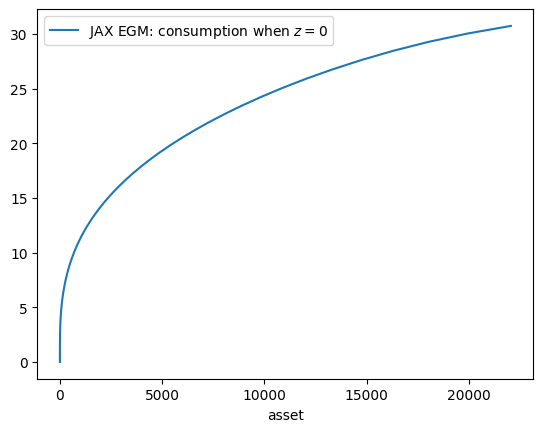

In [ ]:
fig, ax = plt.subplots()

for z in z_range:
    ax.plot(a[:, z],
            σ[:, z],
            label=f"JAX EGM: consumption when $z={z}$")

# ax.plot(a_star_s[:, 0], a_star_s[:, 0], '--', label=f"45 degree line")

ax.set_xlabel('asset')
plt.legend()
plt.show()

In [ ]:
def R(z, ζ):
  return np.exp(a_r * ζ + b_r * z + c_r)

def Y(z, η):
  return np.exp(a_y * η + b_y * z + c_y)

In [ ]:
# mean labor income across different states
Y_mean = [np.mean(Y(z, η_draws)) for z in z_range]
# Mean returns
R_mean = np.mean(R(z, ζ_draws))

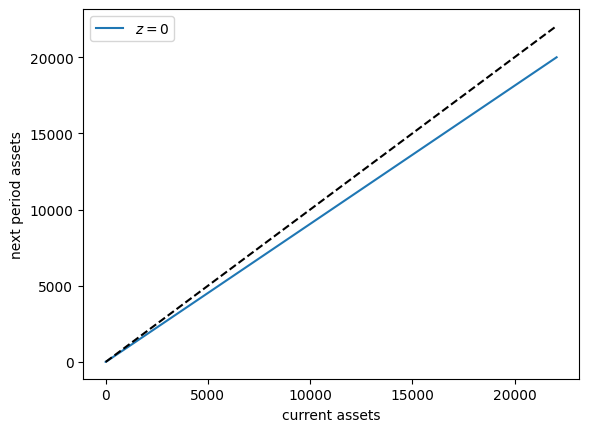

In [ ]:
fig, ax = plt.subplots()
for z in z_range:
    ax.plot(a[:, z], R_mean * (a[:, z] - σ[:, z]) + Y_mean[z] , label=f"$z={z}$")

ax.plot(a[:, 0], a[:, 0], 'k--')
ax.set(xlabel='current assets', ylabel='next period assets')
# ax.xlim(0, 100)
ax.legend()
plt.show()

In [ ]:
T = 500
stars = (a, σ, )
num_households = 10_000_000
size = (num_households, )
constants, sizes, arrays = model
s_grid, z_grid, P, ζ_draws, η_draws = arrays
w_0 = s_grid.mean() / len(s_grid)
ψ_0 = jnp.full(size, w_0)

In [ ]:
%%time

ψ_star, c_star = wealth_time_series_for_loop(ψ_0, T, stars, model, size, rand_seed=772736)

CPU times: user 4min 32s, sys: 29.4 s, total: 5min 2s
Wall time: 4min 59s


In [ ]:
np.min(ψ_star)

Array(1.11242121, dtype=float64)

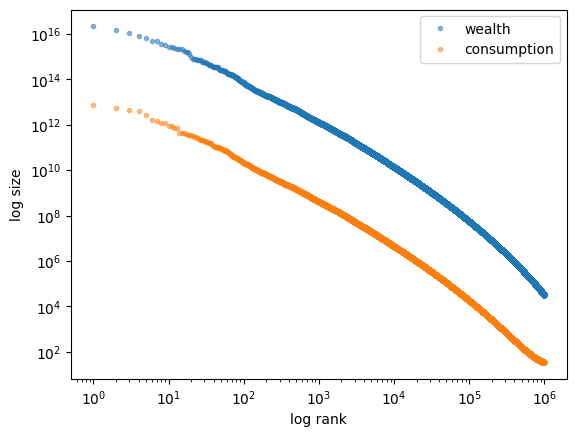

In [ ]:
plotd(ψ_star, c_star, fraction=0.1)

Change the interpolation method.

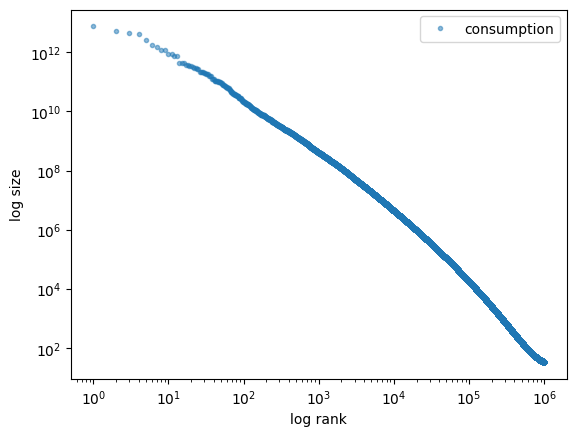

In [ ]:
plots(c_star, fraction=0.1, slabel='consumption')

In [ ]:
cutoff = int(0.9999 * num_households)

In [ ]:
num_households - cutoff

1000

In [ ]:
(alpha, xmin, L), (p, gof) = estimation(ψ_star, cutoff, B=500)

In [ ]:
alpha, p, xmin # wealth tail

(1.6061724252112306, 0.388, 0.029174029939869194)

In [ ]:
(alpha, xmin, L), (p, gof) = estimation(c_star, cutoff, B=500)

In [ ]:
alpha, p, xmin# consumption tail

(1.6008899566280297, 0.89, 0.01718106242610498)